In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
import tensorflow as tf

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
num_data = 16
feat_dim = 5
num_classes = 3
reg_lambda = 0.02
      
embeddings_anchor = np.random.rand(num_data, feat_dim).astype(np.float32)
embeddings_positive = np.random.rand(num_data, feat_dim).astype(np.float32)


labels = np.random.randint(0, num_classes, size=(num_data)).astype(np.float32)

# Reshape labels to compute adjacency matrix.
labels_reshaped = np.reshape(labels, (labels.shape[0], 1))   

In [4]:
embeddings_anchor.shape

(16, 5)

In [5]:
labels_reshaped.shape

(16, 1)

### Compute the loss in NP

In [6]:
reg_term = np.mean(np.sum(np.square(embeddings_anchor), 1))
reg_term += np.mean(np.sum(np.square(embeddings_positive), 1))
reg_term *= 0.25 * reg_lambda

In [7]:
reg_term

0.01759155750274658

In [8]:
embeddings_anchor.shape, embeddings_positive.shape

((16, 5), (16, 5))

In [9]:
similarity_matrix = np.matmul(embeddings_anchor, embeddings_positive.T)

In [10]:
similarity_matrix.shape

(16, 16)

In [11]:
labels_reshaped

array([[2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [2.],
       [1.],
       [2.]], dtype=float32)

In [12]:
labels_remapped = np.equal(labels_reshaped, labels_reshaped.T).astype(np.float32)

In [13]:
labels_remapped

array([[1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
       [1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
       [1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
       [1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
       [1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,

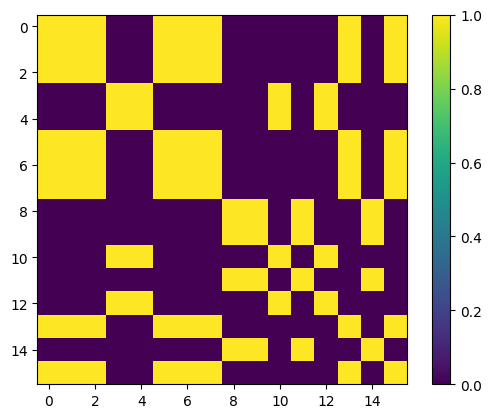

In [14]:
plt.imshow(labels_remapped) #, cmap='tab10_r'
plt.colorbar()
plt.savefig('labels_remapped.png')
plt.show()

In [15]:
labels_remapped /= np.sum(labels_remapped, axis=1, keepdims=True)

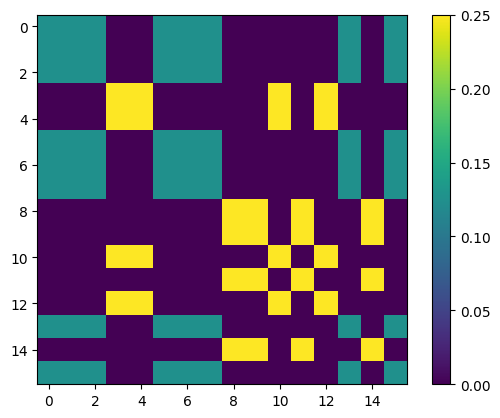

In [16]:
plt.imshow(labels_remapped)
plt.colorbar()
plt.savefig('labels_remapped_norm.png')
plt.show()

In [17]:
xent_loss = math_ops.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
logits=ops.convert_to_tensor(similarity_matrix),
labels=ops.convert_to_tensor(labels_remapped))) #.eval()

#loss_np = xent_loss + reg_term

In [18]:
xent_loss.numpy()

2.8275342

In [19]:
loss_np = xent_loss + reg_term

In [20]:
loss_np.numpy()

2.8451257

### Compute the loss in pytorch

In [21]:
import torch
import torch.nn as nn

import torch.nn.functional as F

In [22]:
def cross_entropy(logits, target, size_average=True):
    if size_average:
        return torch.mean(torch.sum(- target * F.log_softmax(logits, -1), -1))
    else:
        return torch.sum(torch.sum(- target * F.log_softmax(logits, -1), -1))

In [23]:
class NpairLoss(nn.Module):
    """the multi-class n-pair loss"""
    def __init__(self, l2_reg=0.02):
        super(NpairLoss, self).__init__()
        self.l2_reg = l2_reg

    def forward(self, anchor, positive, target):
        batch_size = anchor.size(0)
        target = target.view(target.size(0), 1)

        target = (target == torch.transpose(target, 0, 1)).float()
        target = target / torch.sum(target, dim=1, keepdim=True).float()

        logit = torch.matmul(anchor, torch.transpose(positive, 0, 1))
        loss_ce = cross_entropy(logit, target)
        l2_loss = torch.sum(anchor**2) / batch_size + torch.sum(positive**2) / batch_size

        loss = loss_ce + self.l2_reg*l2_loss*0.25
        return loss

In [24]:
npairloss = NpairLoss()
loss_tc = npairloss(
        anchor=torch.tensor(embeddings_anchor),
        positive=torch.tensor(embeddings_positive),
        target=torch.from_numpy(labels)
        )

In [25]:
loss_tc

tensor(2.8451)

In [26]:
print('pytorch version: ', loss_tc.numpy())
print('numpy version: ',loss_np.numpy())

pytorch version:  2.845126
numpy version:  2.8451257


### Compute the loss in TF

In [27]:
# from tensorflow.python.framework import ops
# from tensorflow.python.ops import math_ops
# from tensorflow_addons.losses import npairs_loss
# #from tensorflow.contrib.losses.python.metric_learning import metric_loss_ops

### References
* https://github.com/ChaofWang/Npair_loss_pytorch/blob/master/Npair_loss.py
* https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/contrib/losses/python/metric_learning/metric_loss_ops.py
* http://www.nec-labs.com/uploads/images/Department-Images/MediaAnalytics/papers/nips16_npairmetriclearning.pdf